# Creating a custom datablock for 3D images and fastai

In [1]:
# export
# default_exp data

import SimpleITK as sitk
import re
import pathlib
import torchvision

from fastai.basics import *
from fastai.vision.all import *
from fastai.callback.all import *

!ln -s ../faimed3d/ faimed3d

In [2]:
# export
from faimed3d.basics import *
from faimed3d.augment import *


## Get data paths and labels

Data is divided into a train, valid and test dataset of different patients, which either have prostate cancer or are healthy. 
Each patient has three MRI sequences: T2, T1map and ADC. These sequences differ in number of slices and resolution. 

At first the paths to the data are specified: 

In [3]:
train = pathlib.Path('../../dl-prostate-mapping/data/train')
valid = pathlib.Path('../../dl-prostate-mapping/data/valid')
test = pathlib.Path('../../dl-prostate-mapping/data/test')

At the moment, I am only interested into the DICOM data, not in the NIfTI segmentations. 

In [4]:
train_files = list(train.rglob('DICOM'))
valid_files = list(valid.rglob('DICOM'))
test_files = list(test.rglob('DICOM'))

To reduce complexity of the data, only the T2 map will be used for the first runs. 

In [5]:
# take only T2 and T1 images for noe
subset_train =[]
for f in train_files: 
    m = re.search(r'T2', str(f)) 
    if hasattr(m, 'string'): subset_train.append(Path(m.string))
        
subset_valid =[]
for f in valid_files: 
    m = re.search(r'T2', str(f)) 
    if hasattr(m, 'string'): subset_valid.append(Path(m.string))
        
subset_test = []
for f in test_files: 
    m = re.search(r'T2', str(f)) 
    if hasattr(m, 'string'): subset_test.append(Path(m.string))

If the patient has prostate cancer or not, can be extracted from the file path. 

In [6]:
labels = ['Gesund', 'ProstataCa']
def label_func(fn): return re.findall(r'(Gesund|ProstataCa)', str(fn))[0]

In [7]:
# export
class ScaleDicom(DisplayedTransform):
    "Transforms a TensorDicom3D volume to float and normalizes the data"
    def __init__(self, div=None, div_mask=1): store_attr()
    
    def encodes(self, x:TensorDicom3D): 
        if self.div is None: 
            return normalize(x.hist_scaled()).float()
        else:
            return (x.hist_scaled()/div).float()
    

In [8]:
# export
def ImageBlock3D(cls=TensorDicom3D):
    "A `TransformBlock` for images of `cls`"
    return TransformBlock(type_tfms=cls.create, batch_tfms=ScaleDicom)

In [26]:
mris = DataBlock(
    blocks = (ImageBlock3D(cls=TensorDicom3D), 
              CategoryBlock),
    get_x = lambda x: x,
    get_y = label_func, 
    item_tfms = ResizeCrop3D(crop_by = (0., 0.1, 0.1), resize_to = (10, 150, 150), perc_crop = True),
    batch_tfms = [*aug_transforms_3d(), RandomCrop3D((0, 25, 25), (0, 25, 25)), PseudoColor],
    splitter = RandomSplitter())

In [27]:
mris.summary(subset_train)

Setting-up type transforms pipelines
Found 92 items
2 datasets of sizes 74,18
Setting up Pipeline: <lambda> -> TensorDicom3D.create
Setting up Pipeline: label_func -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}

Building one sample
  Pipeline: <lambda> -> TensorDicom3D.create
    starting from
      ../../dl-prostate-mapping/data/train/ProstataCa/A0040249360/T2/DICOM
    applying <lambda> gives
      ../../dl-prostate-mapping/data/train/ProstataCa/A0040249360/T2/DICOM
    applying TensorDicom3D.create gives
      TensorDicom3D of size 24x448x448
  Pipeline: label_func -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}
    starting from
      ../../dl-prostate-mapping/data/train/ProstataCa/A0040249360/T2/DICOM
    applying label_func gives
      ProstataCa
    applying Categorize -- {'vocab': None, 'sort': True, 'add_na': False} gives
      TensorCategory(1)

Final sample: (tensor([[[  0.,   0.,   0.,  ...,   0.,   0.,   0.],
         [  0.,   0.,  13.,  ..

In [28]:
dls = mris.dataloaders(subset_train, 
                       batch_size = 4)

In [41]:
# export
def show_batch_3d(dls, max_n=9, **kwargs):
    "Workarround, until implemented into dls as dls.show_batch_3d()"
    xb, yb = dls.one_batch()
    if xb.ndim < 4: raise TypeError('Batch is not a batch of multiple 3D images')
    if xb.ndim == 5: 
        print('Expected 4D tensor but got 5D tensor. Removing the last dimension under the assumption that it is a color channel ')
        return show_multiple_3d_images(xb[:,:,:,:,0], **kwargs)
    if xb.ndim > 5: raise NotImplementedError('Batches with more than 3 Dimensions are currently not supported')
    return show_multiple_3d_images(xb, **kwargs)

Expected 4D tensor but got 5D tensor. Removing the last dimension under the assumption that it is a color channel 


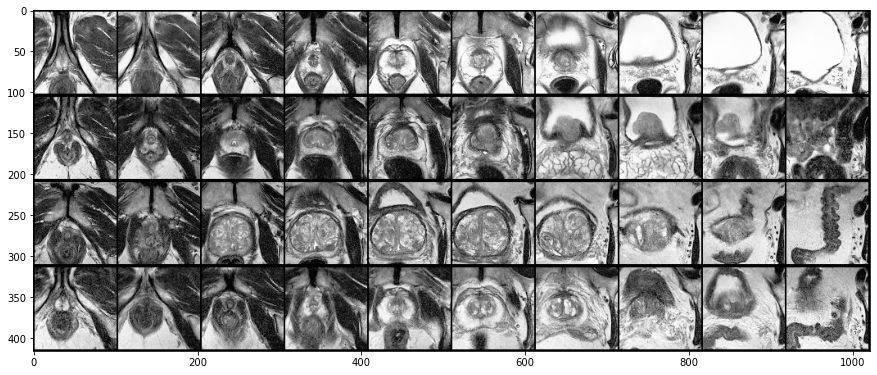

In [42]:
show_batch_3d(dls, axis = 0)

In [44]:
dls.after_item

Pipeline: ResizeCrop3D -- {'crop_by': (0.0, 0.1, 0.1), 'resize_to': (10, 150, 150), 'perc_crop': True, 'p': 1} -> ToTensor

In [17]:
dls.after_batch

Pipeline: ScaleDicom -- {'div': None, 'div_mask': 1} -> RandomWarp3D -- {'p': 0.1} -> RandomDihedral3D -- {'p': 0.1} -> RandomBrightness3D -- {'p': 0.1} -> RandomContrast3D -- {'p': 0.1} -> RandomNoise3D -- {'p': 0.1} -> RandomRotate3DBy -- {'p': 0.1} -> RandomFlip3D -- {'p': 0.1} -> RandomRotate3D -- {'p': 0.1} -> RandomCrop3D -- {'p': 1}